In [59]:
# Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.5.0


In [60]:
# Load : Fashion MNIST Dataest
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


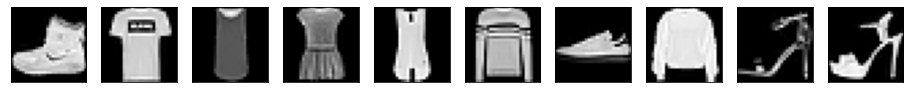

In [61]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [62]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing ##
# Normalization
#데이터 전처리 -> normalization
x_train = x_train/255.  
x_test = x_test/255. 

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


In [63]:
def channel_attention(x,filter, name):
    ####Fill your code####
    #input_feature = (batchsize,h,w,c(channel 개수))
    #output_feature = (batchsize,h,w,c(channel 개수))
  
    # fin = tf.identity(x)

    dense_1 = tf.keras.layers.AveragePooling2D(pool_size=(1, 1))
    dense_2 = tf.keras.layers.Dense(filter/4, activation='relu') 
    dense_3 = tf.keras.layers.Dense(filter, activation='sigmoid') 

    x1 = dense_1(x)
    x1 = dense_2(x1)
    x1 = dense_3(x1)
    x = tf.multiply(x, x1)
    return  x

def spatial_attention(x, name):
    ####Fill your code####
    #input -> conv - > sigmoid -> multiplication
    # fin = tf.identity(x)
    conv_1 = tf.keras.layers.Conv1D(filters=1, kernel_size=3, padding="same" ,activation='sigmoid') 
    
    x1 = conv_1(x)
    x = tf.multiply(x, x1)
    return  x
 
def autoencoder_block(x, filter, name): 
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    return x

In [64]:
##############################################
# Add Attention Block in AutoEncoder network #
#적절한 위치에 배치하기 #
##############################################

def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_channel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1_1')
    x = channel_attention(x, 16, 'channel_attention')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1_1')(x)
    
    x = autoencoder_block(x, 32, 'encoder2_2')
    x = channel_attention(x,32,'channel_attention')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2_2')(x)
 
    x = autoencoder_block(x, 64, 'encoder3_3')
    encoded_img = channel_attention(x,64,'channel_attention')
    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1_1')
    x = channel_attention(x,64,'channel_attention')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1_1')(x)
    
    x = autoencoder_block(x, 32, 'decoder2_2')
    x = channel_attention(x,32,'channel_attention')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2_2')(x)

    x = autoencoder_block(x, 16, 'decoder3_3')
    x = channel_attention(x, 16,'channel_attention')
    
    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv_1')(x)
    
    
    return decoded_img   

def autoencoder_spatial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = spatial_attention(x, 'spatial_attention')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)

    x = autoencoder_block(x, 32, 'encoder2')
    x = spatial_attention(x,'spatial_attention')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)

    x = autoencoder_block(x, 64, 'encoder3')
    encoded_img = spatial_attention(x, 'spatial_attention')
    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = spatial_attention(x,'spatial_attention')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    
    x = autoencoder_block(x, 32, 'decoder2')
    x = spatial_attention(x,'spatial_attention')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    
    x = autoencoder_block(x, 16, 'decoder3')
    x = spatial_attention(x ,'spatial_attention')
    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    
    return decoded_img   

#################

def autoencoder_channel_spatial(input):
  x = autoencoder_channel(input)
  x = autoencoder_spatial(x)
  return x
 

def autoencoder_spatial_channel(input):
  x = autoencoder_spatial(input)
  x = autoencoder_channel(x)
  return x

def paral_mul(input) :
  return autoencoder_spatial(input) * autoencoder_channel(input)

def paral_add(input) :
  return autoencoder_spatial(input) + autoencoder_channel(input)


# Normal AutoEncoder Model Create / Summary
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_data = autoencoder_channel(input_data)
output_spatial_data = autoencoder_spatial(input_data)
output_channel_spatial_data = autoencoder_channel_spatial(input_data)
output_spatial_channel_data = autoencoder_spatial_channel(input_data)
output_paral_add_data = paral_add(input_data)
output_paral_mul_data = paral_mul(input_data)

model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel  = tf.keras.Model(inputs=input_data, outputs=output_channel_data)
model_spatial  = tf.keras.Model(inputs=input_data, outputs=output_spatial_data)
model_channel_spatial  = tf.keras.Model(inputs=input_data, outputs=output_channel_spatial_data)
model_spatial_channel  = tf.keras.Model(inputs=input_data, outputs=output_spatial_channel_data)
model_paral_add = tf.keras.Model(inputs=input_data, outputs=output_paral_add_data)
model_paral_mul  = tf.keras.Model(inputs=input_data, outputs=output_paral_mul_data)

model.summary()
model_channel.summary()
model_spatial.summary()
model_channel_spatial.summary()
model_spatial_channel.summary()
model_paral_add.summary()
model_paral_mul.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder1_conv (Conv2D)       (None, 28, 28, 16)        160       
_________________________________________________________________
encoder1_bn (BatchNormalizat (None, 28, 28, 16)        64        
_________________________________________________________________
encoder1_relu (ReLU)         (None, 28, 28, 16)        0         
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
encoder2_conv (Conv2D)       (None, 14, 14, 32)        4640      
_________________________________________________________________
encoder2_bn (BatchNormalizat (None, 14, 14, 32)        128   

In [65]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_spatial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_channel_spatial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_spatial_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_paral_add.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_paral_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [52]:
# Training
print('Training Model')

# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history = model.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_channel = model_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_spatial = model_spatial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_channel_spatial = model_channel_spatial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_spatial_channel = model_spatial_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_paral_add = model_paral_add.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_paral_mul = model_paral_mul.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=5,
                    shuffle=True,
                    validation_data=(x_test, x_test))


Training Model
Epoch 1/5
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 3/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 5/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 1/5
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/5
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/5
3750/3750 [==========================

In [53]:
# Model Predict
recons = model.predict(x_test)
recons_channel = model_channel.predict(x_test)
recons_spatial = model_spatial.predict(x_test)
recons_channel_spatial = model_channel_spatial.predict(x_test)
recons_spatial_channel = model_spatial_channel.predict(x_test)
recons_paral_add = model_paral_add.predict(x_test)
recons_paral_mul = model_paral_mul.predict(x_test)

In [54]:
recons = recons.reshape(-1, 28, 28)
recons_channel = recons.reshape(-1, 28, 28)
recons_spatial = recons.reshape(-1, 28, 28)
recons_channel_spatial = recons.reshape(-1, 28, 28)
recons_spatial_channel = recons.reshape(-1, 28, 28)
recons_paral_add = recons.reshape(-1, 28, 28)
recons_paral_mul = recons.reshape(-1, 28, 28)

test_imgs = (x_test * 255).reshape(-1, 28, 28)

In [55]:
history_channel.history

{'loss': [0.0062109665013849735,
  0.003036567009985447,
  0.002563495421782136,
  0.0023143624421209097,
  0.0021487765479832888],
 'mse': [0.006210964173078537,
  0.0030365625862032175,
  0.002563496120274067,
  0.0023143624421209097,
  0.0021487760823220015],
 'val_loss': [0.003510928712785244,
  0.0027703780215233564,
  0.00228464649990201,
  0.0021116486750543118,
  0.0019606209825724363],
 'val_mse': [0.003510927315801382,
  0.002770377788692713,
  0.0022846462670713663,
  0.0021116500720381737,
  0.0019606202840805054]}

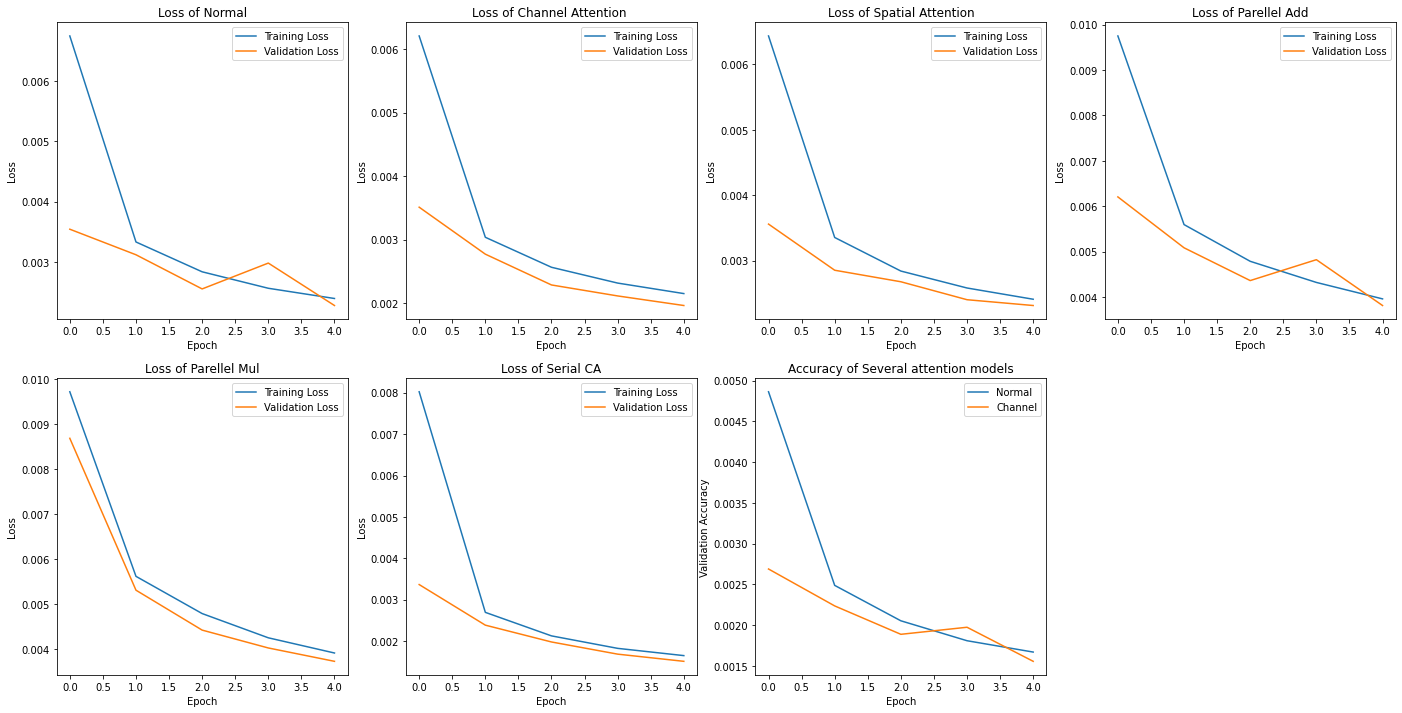

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(history_channel.history['loss'])
plt.plot(history_channel.history['val_loss'])
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(history_spatial.history['loss'])
plt.plot(history_spatial.history['val_loss'])
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(history_channel_spatial.history['loss'])
plt.plot(history_channel_spatial.history['val_loss'])
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(history_spatial_channel.history['loss'])
plt.plot(history_spatial_channel.history['val_loss'])
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,6)
plt.plot(history_paral_add.history['loss'])
plt.plot(history_paral_add.history['val_loss'])
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,7)
plt.plot(history_paral_mul.history['loss'])
plt.plot(history_paral_mul.history['val_loss'])
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.title('Accuracy of Several attention models')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)

plt.show()

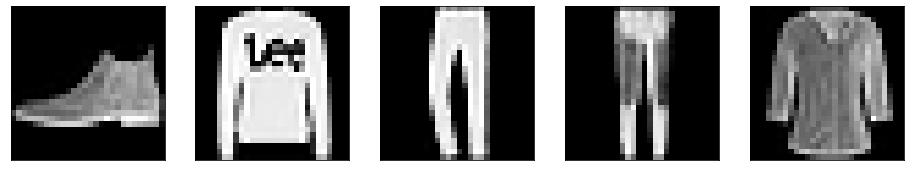

In [57]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

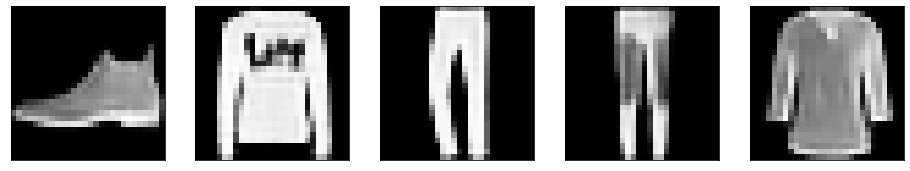

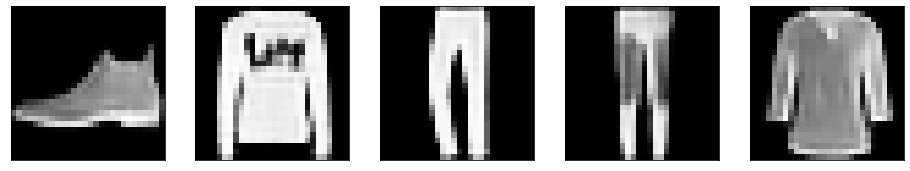

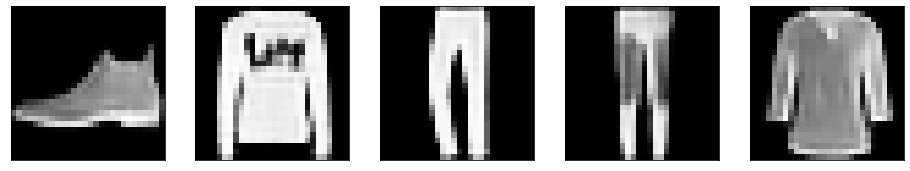

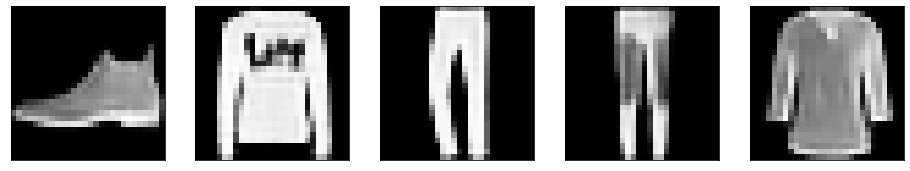

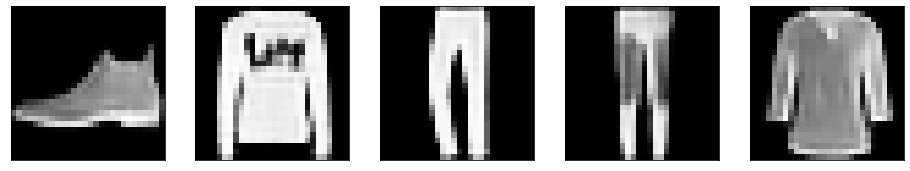

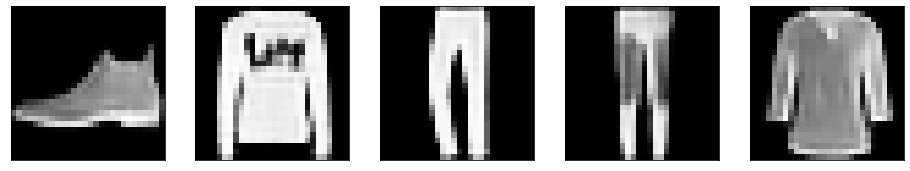

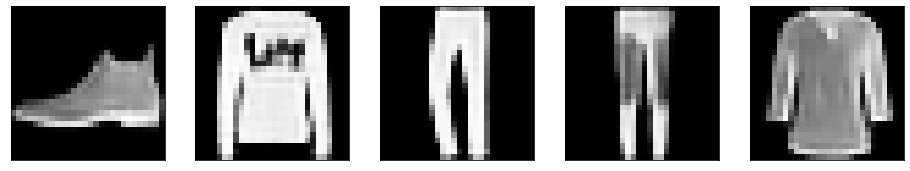

In [58]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_spatial_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_paral_add[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_paral_mul[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()